In [316]:
import numpy as np
import random

In [317]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [318]:
def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

In [319]:
def sampleChania(Chania, n_points):
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

## Read dataset

In [320]:
Chania = np.genfromtxt('processedChania.csv', delimiter=',')

## Privitizer and Adversary

In [321]:
def privatizer(x):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):
        l1 = tf.layers.dense(x, 16, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, x.shape[1].value)
    return l2


def adversary(y):
    with tf.variable_scope("ad", reuse=tf.AUTO_REUSE):
        l1 = tf.layers.dense(y, 16, activation=tf.nn.relu)
        # num users = 5
        l2 = tf.layers.dense(l1, 5, activation=tf.nn.softmax)
    return l2

## Signal Map Error

In [346]:
def signal_map_error(x, y):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):

        # build model from input
        inputmodel = keras.Sequential([
            keras.layers.Dense(10, input_shape=(2, ), activation=tf.nn.relu),
            keras.layers.Dense(10, activation=tf.nn.relu),
            keras.layers.Dense(1)        
        ])
        optimizer = tf.train.FtrlOptimizer(0.001)
        inputmodel.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        inputmodel.fit(x[:,2:], x[:,1], steps_per_epoch=1, epochs=100, verbose=0)   

        # build model from output
        outputmodel = keras.Sequential([
            keras.layers.Dense(10, input_shape=(2, ), activation=tf.nn.relu),
            keras.layers.Dense(10, activation=tf.nn.relu),
            keras.layers.Dense(1)        
        ])
        outputmodel.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        outputmodel.fit(y[:,2:], y[:,1], steps_per_epoch=1, epochs=100, verbose=0)  
        
        # compare inputmodel(input) and outputmodel(input)
        # map_error = tf.reduce_mean(tf.squared_difference(inputmodel(x[:,2:]), outputmodel(x[:,2:])))
        
        # compare inputmodel(testpoints) and outputmodel(testpoints)
        testpoints = np.mgrid[-1:1:15j, -1:1:15j].reshape(2,-1).T
        grid = tf.constant(testpoints, dtype=tf.float32)
        map_error = tf.reduce_mean(tf.squared_difference(inputmodel(grid), outputmodel(grid)))

    return map_error, inputmodel, outputmodel

## Classification Error

In [323]:
def classification_error(z, trueusers):
    with tf.variable_scope("ad", reuse=tf.AUTO_REUSE):
        class_error = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, z))
    return class_error

## Privatizer Loss

In [324]:
def privatizer_loss(x, y, trueusers, threshold):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):
        penalty = 2
        
        c_e = classification_error(z, trueusers)
        s_m_e, _, _ = signal_map_error(x, y)
        
        zero = tf.constant(0, dtype=tf.float32)
        loss = -1*c_e + penalty*tf.math.maximum(zero, threshold-s_m_e)
        
    return loss        

## GAP

In [325]:
# initialize privatizer and adversary
# for i in range(n):
#     choose sample points
#     y = privatizer(x)
#     z = adversary(y)
#     for k in range(100):
#         train adversary
#     train privatizer

In [326]:
# initialize 
threshold = tf.constant(0.5, dtype=tf.float32)
x, trueusers = sampleChania(Chania, n_points=100)
y = privatizer(x)
z = adversary(y)
n = 1

# initialize loss variables
class_error = classification_error(z, trueusers)
priv_loss = privatizer_loss(x, y, trueusers, threshold)

# initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(n):

    # sample points
    x, trueusers = sampleChania(Chania, n_points=100)
    
    # run data through privatizer
    y = privatizer(x)
    
    # run data through adversary
    z = adversary(y)

    ad_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="ad")
    ad_train = tf.train.GradientDescentOptimizer(0.01).minimize(class_error, var_list = ad_vars)
    
    priv_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="priv")
    priv_train = tf.train.GradientDescentOptimizer(0.01).minimize(priv_loss, var_list = priv_vars)
    
    for k in range(1):
        
        # train adversary
        _, a_loss = sess.run((ad_train, class_error))
        
    # train privatizer
    _, p_loss = sess.run((priv_train, priv_loss))
    
    print("Iterations: %d\t Adversary loss: %.4f\t Privatizer loss: %.4f"%(i, a_loss,p_loss))

Iterations: 0	 Adversary loss: 1.7233	 Privatizer loss: -0.9997


## Visualization

In [327]:
def plot_rssi(x, y, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
    ax[0].set_title("True Received Signal Strengths")
    
    ax[1].scatter(yarray[:,3], yarray[:,2], c=yarray[:,1])
    ax[1].set_title("Obfuscated Received Signal Strengths")

In [336]:
def plot_users(x, y, z, trueusers, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    zarray = z.eval(session=sess)
    u = trueusers.eval(session=sess)
    
    fig, ax1 = plt.subplots(1, 2, figsize=(15,5))
    
    ax1[0].scatter(xarray[:,3], xarray[:,2], c=u)
    ax1[0].set_title("User Labels")
    
    ax1[1].scatter(yarray[:,3], yarray[:,2], c=u)
    ax1[1].set_title("Obfuscated data - User Labels")
    
    fig, ax2 = plt.subplots(1, 2, figsize=(15,5))
    
    ax2[0].scatter(xarray[:,3], xarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[0].set_title("User Labels estimated by adversary")
    
    ax2[1].scatter(yarray[:,3], yarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[1].set_title("Obfuscated data - User Labels estimated by adversary")

In [349]:
def plot_maps(inputmodel, outputmodel, sess):   
    testpoints = np.mgrid[-1:1:15j, -1:1:15j].reshape(2,-1).T
    grid = tf.constant(testpoints, dtype=tf.float32)

    inputmap = inputmodel.predict_on_batch(grid.eval(session=sess))
    outputmap = outputmodel.predict_on_batch(grid.eval(session=sess))

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
    ax[0].set_title("Map created from True Data")
    ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
    ax[1].set_title("Map created from Obfuscated Data")

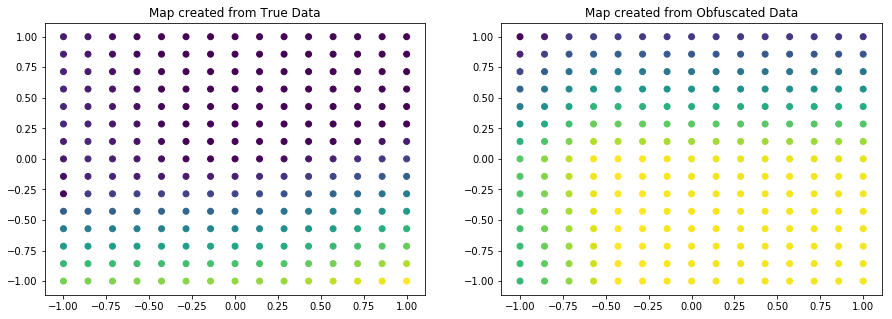

In [350]:
plot_rssi(x, y, sess)
plot_users(x, y, z, trueusers, sess)
_, inputmodel, outputmodel = signal_map_error(x, y)
plot_maps(inputmodel, outputmodel, sess)

## Notes

#### Metaparameters to consider playing with:
1. number of layers & units in privatizer and adversary
2. number of layers and & units in signal map models
3. penalty
4. threshold
5. number of points to train on each iteration
6. ratio of adversary training steps to privatizer training steps

#### Additional note:  
I am calculating signal map error as the mean square error of the ouput of two models when they are both fed with the input x. Should I instead be feeding a uniform input of hypothetical points (like the visualization?)

## Training hyperparameters

In [409]:
def train_GAP(priv_nlayers, priv_nunits, ad_nlayers, ad_nunits, map_nlayers, map_nunits, map_epochs, penalty_value, threshold_value, samplesize, n_iterations):

    f = open(("train_GAP/"+str((priv_nlayers, priv_nunits, ad_nlayers, ad_nunits, map_nlayers, map_nunits, map_epochs, penalty_value, threshold_value, samplesize, n_iterations))+".txt"), "w")
    f.write("%d layers with %d units in the privatizer\n"%(priv_nlayers, priv_nunits))
    f.write("%d layers with %d units in the adversary\n"%(ad_nlayers, ad_nunits))
    f.write("%d layers with %d units in the map model, trained for %d epochs\n"%(map_nlayers, map_nunits, map_epochs))
    f.write("utility distortion penalty of %d\n"%(penalty_value))
    f.write("minimum acceptable distortion of %d\n"%(threshold_value))
    f.write("train on %d samples\n"%(samplesize))
    f.write("try %d iterations unless loss converges\n\n"%(n_iterations))
    
    def privatizer(x):
        with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):
            l1 = tf.layers.dense(x, priv_nunits, activation=tf.nn.relu)
            if priv_nlayers == 1:
                l2 = tf.layers.dense(l1, x.shape[1].value)
                return l2
            if priv_nlayers == 2:
                l2 = tf.layers.dense(l1, priv_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, x.shape[1].value)
                return l3
            if priv_nlayers == 3:
                l2 = tf.layers.dense(l1, priv_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, priv_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, x.shape[1].value)
                return l4
            if priv_nlayers == 4:
                l2 = tf.layers.dense(l1, priv_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, priv_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, priv_nunits, activation=tf.nn.relu)
                l5 = tf.layers.dense(l4, x.shape[1].value)
                return l5
            if priv_nlayers == 5:
                l2 = tf.layers.dense(l1, priv_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, priv_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, priv_nunits, activation=tf.nn.relu)
                l5 = tf.layers.dense(l4, priv_nunits, activation=tf.nn.relu)
                l6 = tf.layers.dense(l5, x.shape[1].value)
                return l6
            else:
                raise ValueError("Can't handle more than 5 hidden layers right now")

    def adversary(y):
        with tf.variable_scope("ad", reuse=tf.AUTO_REUSE):
            l1 = tf.layers.dense(y, ad_nunits, activation=tf.nn.relu)
            if ad_nlayers == 1:
                l2 = tf.layers.dense(l1, 5, activation=tf.nn.softmax)
                return l2
            if ad_nlayers == 2:
                l2 = tf.layers.dense(l1, ad_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, 5, activation=tf.nn.softmax)
                return l3
            if ad_nlayers == 3:
                l2 = tf.layers.dense(l1, ad_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, ad_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, 5, activation=tf.nn.softmax)
                return l4
            if ad_nlayers == 4:
                l2 = tf.layers.dense(l1, ad_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, ad_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, ad_nunits, activation=tf.nn.relu)
                l5 = tf.layers.dense(l4, 5, activation=tf.nn.softmax)
                return l5
            if ad_nlayers == 5:
                l2 = tf.layers.dense(l1, ad_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, ad_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, ad_nunits, activation=tf.nn.relu)
                l5 = tf.layers.dense(l4, ad_nunits, activation=tf.nn.relu)
                l6 = tf.layers.dense(l5, 5, activation=tf.nn.softmax)
                return l6
            else:
                raise ValueError("Can't handle more than 5 hidden layers right now")
    
    def signal_map_error(x, y):
        with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):

            # build model from input
            inputmodel = keras.Sequential()
            inputmodel.add(keras.layers.Dense(map_nunits, input_shape=(2, ), activation=tf.nn.relu))
            for l in range(map_nlayers-1):
                inputmodel.add(keras.layers.Dense(map_nunits, activation=tf.nn.relu))
            inputmodel.add(keras.layers.Dense(1))
            optimizer = tf.train.FtrlOptimizer(0.001)
            inputmodel.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
            inputmodel.fit(x[:,2:], x[:,1], steps_per_epoch=1, epochs=map_epochs, verbose=0)   

            # build model from output
            outputmodel = keras.Sequential()
            outputmodel.add(keras.layers.Dense(map_nunits, input_shape=(2, ), activation=tf.nn.relu))
            for l in range(map_nlayers-1):
                outputmodel.add(keras.layers.Dense(map_nunits, activation=tf.nn.relu))
            outputmodel.add(keras.layers.Dense(1))  
            outputmodel.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
            outputmodel.fit(y[:,2:], y[:,1], steps_per_epoch=1, epochs=map_epochs, verbose=0)  

            # compare inputmodel(input) and outputmodel(input)
            # map_error = tf.reduce_mean(tf.squared_difference(inputmodel(x[:,2:]), outputmodel(x[:,2:])))

            # compare inputmodel(testpoints) and outputmodel(testpoints)
            testpoints = np.mgrid[-1:1:15j, -1:1:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)
            map_error = tf.reduce_mean(tf.squared_difference(inputmodel(grid), outputmodel(grid)))

        return map_error, inputmodel, outputmodel
    
    def classification_error(z, trueusers):
        with tf.variable_scope("ad", reuse=tf.AUTO_REUSE):
            class_error = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, z))
        return class_error
    
    def privatizer_loss(x, y, trueusers, threshold):
        with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):
            penalty = penalty_value

            c_e = classification_error(z, trueusers)
            s_m_e, _, _ = signal_map_error(x, y)

            zero = tf.constant(0, dtype=tf.float32)
            loss = -1*c_e + penalty*tf.math.maximum(zero, threshold-s_m_e)

        return loss        
    
    # initialize 
    threshold = tf.constant(threshold_value, dtype=tf.float32)
    x, trueusers = sampleChania(Chania, samplesize)
    y = privatizer(x)
    z = adversary(y)
    n = n_iterations

    # initialize loss variables
    class_error = classification_error(z, trueusers)
    priv_loss = privatizer_loss(x, y, trueusers, threshold)

    # initialize session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    epsilon1 = 0.0001
    previous_loss1 = 0
    for i in range(n):

        # sample points
        x, trueusers = sampleChania(Chania, n_points=100)

        # run data through privatizer
        y = privatizer(x)

        # run data through adversary
        z = adversary(y)

        ad_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="ad")
        ad_train = tf.train.GradientDescentOptimizer(0.01).minimize(class_error, var_list = ad_vars)

        priv_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="priv")
        priv_train = tf.train.GradientDescentOptimizer(0.01).minimize(priv_loss, var_list = priv_vars)

        epsilon2 = 0.0001
        previous_loss2 = 0
        for k in range(n):

            # train adversary
            _, a_loss = sess.run((ad_train, class_error))
            if abs(previous_loss2 - a_loss) <= epsilon2:
                break
            previous_loss2 = a_loss

        # train privatizer
        _, p_loss = sess.run((priv_train, priv_loss))
        if abs(previous_loss1 - p_loss) <= epsilon1:
            break
        previous_loss1 = p_loss

        f.write("Iterations: %d\t Adversary loss: %.4f\t Privatizer loss: %.4f\n"%(i, a_loss,p_loss))
        
    print("Done")

In [410]:
priv_nlayers = 1
priv_nunits = 16
ad_nlayers = 1
ad_nunits = 16
map_nlayers = 1
map_nunits = 16
map_epochs = 10
penalty_value = 2
threshold_value = 0.5
samplesize = 10
n_iterations = 1

train_GAP(priv_nlayers, priv_nunits, ad_nlayers, ad_nunits, map_nlayers, map_nunits, map_epochs, penalty_value, threshold_value, samplesize, n_iterations)

Done
